In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

INPUT = "../mumbai_reviews_with_flags.csv"  # adjust if your notebook sits elsewhere
NEGATIVE_STAR_MAX = 3  # count issue only if rating <= 3; 5★ always excluded

# If you run notebook from project root instead of notebooks/, use: INPUT = "mumbai_reviews_with_flags.csv"
print("Working dir:", os.getcwd())
print("Expecting file at:", os.path.abspath(INPUT))


Working dir: C:\Users\trive\OneDrive\Desktop\Test_Jupyter\Beserva_India_Project\Notebooks
Expecting file at: C:\Users\trive\OneDrive\Desktop\Test_Jupyter\Beserva_India_Project\mumbai_reviews_with_flags.csv


In [2]:
df = pd.read_csv(INPUT)
print("Rows:", len(df))
df.head(3)


Rows: 1786


,place_id,place_name,address,place_overall_rating,place_review_count,review_rating,text,time,relative_time,language,...,kw_booking,kw_schedule,kw_cancel,kw_no_show,kw_whatsapp,kw_wait_delay,is_booking_issue,is_timing_issue,is_negative_le2,is_negative_le3
0,ChIJl3Q-jWrO5zsRwVf4CoA8ATA,New Light Beauty saloon,"219/23, Shop 6, Belasis Road, Near tahoora swe...",4.8,1298,1,"hi guys! i am seema jadhav, new light beauty s...",1753954074,2 weeks ago,en,...,False,False,False,False,False,False,False,False,True,True
1,ChIJl3Q-jWrO5zsRwVf4CoA8ATA,New Light Beauty saloon,"219/23, Shop 6, Belasis Road, Near tahoora swe...",4.8,1298,5,zainab khan.\nyet till i am satisfy\nlet see a...,1754669115,a week ago,en,...,False,False,False,False,False,False,False,False,False,False
2,ChIJl3Q-jWrO5zsRwVf4CoA8ATA,New Light Beauty saloon,"219/23, Shop 6, Belasis Road, Near tahoora swe...",4.8,1298,5,this is flossy 2.8.2025\n\nit was pleasure com...,1754148030,2 weeks ago,en,...,False,False,False,False,False,False,False,False,False,False


In [3]:
need = ["place_id", "place_name", "review_rating", "text"]
missing = [c for c in need if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

df["review_rating"] = pd.to_numeric(df["review_rating"], errors="coerce")
df["text"] = df["text"].fillna("").astype(str).str.lower()

# Gather any issue flags that exist in your CSV
candidate_flags = [
    "is_appt_issue","is_booking_issue","is_timing_issue",
    "kw_appointment","kw_booking","kw_schedule","kw_cancel",
    "kw_no_show","kw_wait_delay","kw_whatsapp"
]
flag_cols = [c for c in candidate_flags if c in df.columns]
flag_cols


['is_booking_issue',
 'is_timing_issue',
 'kw_appointment',
 'kw_booking',
 'kw_schedule',
 'kw_cancel',
 'kw_no_show',
 'kw_wait_delay',
 'kw_whatsapp']

In [4]:
if not flag_cols:
    raise ValueError("No issue/keyword flag columns found. Re-run your flagging step to create them.")

df["is_issue_anyflag"] = df[flag_cols].any(axis=1)
df["is_issue_effective"] = df["is_issue_anyflag"] & (df["review_rating"] <= NEGATIVE_STAR_MAX)

df[["review_rating","is_issue_anyflag","is_issue_effective"]].head(5)


,review_rating,is_issue_anyflag,is_issue_effective
0,1,False,False
1,5,False,False
2,5,False,False
3,5,False,False
4,5,False,False


In [5]:
if "place_overall_rating" in df.columns:
    df["place_overall_rating"] = pd.to_numeric(df["place_overall_rating"], errors="coerce")
    place_metrics = (
        df.groupby("place_id")
          .agg(place_name=("place_name","first"),
               rank_metric=("place_overall_rating","first"),
               sample_avg=("review_rating","mean"))
          .reset_index()
    )
    place_metrics["rank_metric"] = place_metrics["rank_metric"].fillna(place_metrics["sample_avg"])
else:
    place_metrics = (
        df.groupby("place_id")
          .agg(place_name=("place_name","first"),
               rank_metric=("review_rating","mean"))
          .reset_index()
    )

place_metrics = place_metrics.sort_values("rank_metric", ascending=True, kind="mergesort").reset_index(drop=True)
place_metrics["quintile"] = pd.qcut(place_metrics.index, 5, labels=[1,2,3,4,5])  # 1=worst, 5=best

# merge quintile back to review rows
df_q = df.merge(place_metrics[["place_id","quintile"]], on="place_id", how="left")
place_metrics.head(3)


,place_id,place_name,rank_metric,sample_avg,quintile
0,ChIJQTgIjeXO5zsR9AL-Hp3LsrU,Jawed Habib Hair Studio | Haircut | Hair Strai...,3.8,1.8,1
1,ChIJZXN8xSHJ5zsR-WDKrG7K7dI,Aura Thai Spa - Best Spa in Mumbai,3.9,3.0,1
2,ChIJhd7qNcHR5zsRMUFH8r115og,The Palms Spa,4.0,3.0,1


In [6]:
summary = (
    df_q.groupby("quintile")
        .agg(n_reviews=("text","size"),
             n_issue_reviews=("is_issue_effective","sum"))
        .reset_index()
        .sort_values("quintile")
)
summary["pct_issue_reviews"] = (summary["n_issue_reviews"] / summary["n_reviews"] * 100).round(2)
summary["negative_star_max"] = NEGATIVE_STAR_MAX

summary


C:\Users\trive\AppData\Local\Temp\ipykernel_14720\208851603.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_q.groupby("quintile")


,quintile,n_reviews,n_issue_reviews,pct_issue_reviews,negative_star_max
0,1,360,24,6.67,3
1,2,360,10,2.78,3
2,3,360,6,1.67,3
3,4,360,4,1.11,3
4,5,346,4,1.16,3


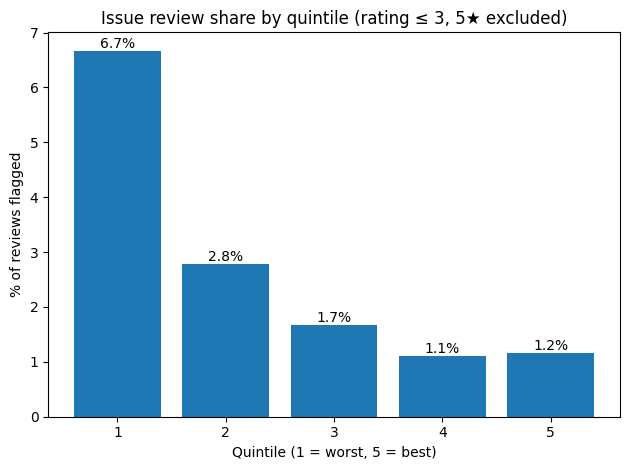

In [7]:
plt.figure()
plt.bar(summary["quintile"].astype(str), summary["pct_issue_reviews"])
plt.title(f"Issue review share by quintile (rating ≤ {NEGATIVE_STAR_MAX}, 5★ excluded)")
plt.xlabel("Quintile (1 = worst, 5 = best)")
plt.ylabel("% of reviews flagged")
for i, v in enumerate(summary["pct_issue_reviews"]):
    plt.text(i, v, f"{v:.1f}%", ha="center", va="bottom")
plt.tight_layout()


In [10]:
agg = (
    df_q.groupby("place_id")
        .agg(place_name=("place_name","first"),
             n_reviews=("text","size"),
             n_issue_reviews=("is_issue_effective","sum"),
             avg_review_star=("review_rating","mean"))
        .reset_index()
)
if "place_overall_rating" in df.columns:
    over = df.groupby("place_id").agg(place_overall_rating=("place_overall_rating","first")).reset_index()
    agg = agg.merge(over, on="place_id", how="left")

agg["issue_rate"] = agg["n_issue_reviews"] / agg["n_reviews"]
offenders = (
    agg[(agg["n_reviews"] >= 3) & (agg["n_issue_reviews"] >= 1)]
      .sort_values(["issue_rate","n_issue_reviews","n_reviews"], ascending=[False, False, False])
      .head(10)
      .copy()
)
off_cols = ["place_name","n_reviews","n_issue_reviews","issue_rate","avg_review_star"]
if "place_overall_rating" in offenders.columns:
    off_cols.insert(1,"place_overall_rating")
offenders["issue_rate"] = (offenders["issue_rate"] * 100).round(2)
# offenders[off_cols]


In [9]:
os.makedirs("../analysis", exist_ok=True)
summary.to_csv("../analysis/quintile_comparison.csv", index=False)
offenders.to_csv("../analysis/top10_offenders.csv", index=False)
plt.gcf().savefig("../analysis/quintile_bar.png", dpi=150)
"Saved to /analysis"


'Saved to /analysis'

<Figure size 640x480 with 0 Axes>